<img src= 
"https://realestateagentpdx.com/wp-content/uploads/2011/12/zillow-zestimate-correct.jpg" 
         alt="GeeksforGeeks logo" 
         align="right"> 
         
<h1><font size="7" color="#3A71CD">Zestimating the Error of Our Ways

</h1>
    
Author: Gilbert Noriega

<div class="alert alert-block alert-info"><b>         </div>

# Executive Summary

- Who:  Zillow Team
- What: Finding the drivers of single unit/single family homes
- Where: Southern California
- When: 2017
- Why: Reduce our error for zestimates
- How:
    - Location
    - Heating system
    - Home price per sqft
    - Acreage 
    - Tax Rate
- Results: The best model was 1.47% worse than the baseline

- Next Steps
    - Look into transaction date as an option 
    - Obtain more complete data or investigate missing values
    - choose a different combination of clusters
   

<div class="alert alert-block alert-info"><b>         </div>

In [63]:
#starting libraries
import pandas as pd
import numpy as np

#exploring libraries
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy import stats
from scipy.stats import f_oneway

sns.set(rc = {'figure.figsize':(12,9)})

from wrangle_zillow import wrangle_zillow, scaled_zillow_columns
from explore import elbow_plot, run_kmeans, add_to_train

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

#modeling libraries
from model import linearReg_train, lassoLars_train, poly_linearReg_train, linearReg_validate, lassoLars_validate, poly_linearReg_validate

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error




import warnings
warnings.filterwarnings("ignore")

# Acquire
<div class="alert alert-block alert-info">
    
- The function, get_zillow_data, uses the SQL query to bring in data from the Zillow database to include only single unit residential properties whose last transactions was in 2017. We joined a several tables to get the last transaction which gave us a total row count of 52,442 and a column count of 69.
    
</div>

# Prepare
#### Filled in Nulls
<div class="alert alert-block alert-info">  
    
- There were a lot of nulls and after a little exploration, I was able to fill in `poolcnt`, `fireplacecnt`, and `heatingorsystemdesc` with zeros. It was the only choice unaccounted for and I believe it was just left out.

- Filled in all the nulls for `unitcnt` with 1 since thats what we filtered out for.
</div>

#### Filtered Outliers
<div class="alert alert-block alert-info">

- removed `bedroomcnt` that were listed as zero or greater than 6 because not all counties had more than 6 bedrooms and cannot definitively guess how many bedrooms there are

- removed `calculatedfinishedsquarefeet` that was less than 400 and greater than 7000 to not skew the data later when we scale

- removed all `unitcnt` that were not listed as one because we want single unit properties
    
- removed `'Yes', 'Gravity', 'Radiant', 'Baseboard', 'Solar', 'Forced air'` from `heatingorsystemdesc` because they did not make up the majority
    
- left with 51,404 rows
    
</div>
    

#### Created New Features
<div class="alert alert-block alert-info">
    
- `age`from `yearbuilt`
    
- `taxrate` from `taxamount/taxvaluedollarcnt`
    
- `acres` from `lotsizesquarefeet`
    
- `structure_dollar_per_sqft` from `structuretaxvaluedollarcnt/calculatedfinishedsquarefeet`
    
- `land_dollar_per_sqft` from `landtaxvaluedollarcnt/lotsizesquarefeet`
    
- `bed_bath_ratio` from `bedroomcnt/bathroomcnt`
    
- `county` from `fips`
    
- dummy variables for `county` and `heatingsystemordesc`
    
- `error` from `logerror`
    
- filtered out outliers from `acres` & `taxrate`
    
- dropped duplicate columns
    
- left with 50,939 rows and 73 columns
    
</div>

#### Dropped Nulls/Unneccesary Information
<div class="alert alert-block alert-info">     
    
- filter out columns and rows with more than 40% null values
    
- dropped duplicate columns or columns with too much incomplete information
    
- left with 49921 rows and 24 columns
    
</div>

#### Prepped for Explore
<div class="alert alert-block alert-info">        
    
- Created a function called `wrangle_zillow` that splits the data into train, validate, test
    
- Created another split of scaled train, validate, test called `scaled_zillow_columns`
    
</div>

# Exploration

In [2]:
train, validate, test = wrangle_zillow()

In [3]:
X_train = train.drop(columns=['error'])
y_train = train[['error']]

In [4]:
abs(train.corr().error).sort_values(ascending = False)

error                           1.000000
structure_dollar_per_sqft       0.032991
bedroomcnt                      0.031790
calculatedfinishedsquarefeet    0.030269
orange                          0.027129
no_heating                      0.027107
longitude                       0.025376
los_angeles                     0.025052
latitude                        0.023663
taxrate                         0.020288
central_heating                 0.018522
poolcnt                         0.015922
roomcnt                         0.015894
age                             0.015559
parcelid                        0.015402
land_dollar_per_sqft            0.014654
acres                           0.010879
floor_wall_heating              0.009072
fireplacecnt                    0.002726
bed_bath_ratio                  0.002376
regionidcity                    0.001073
regionidzip                     0.000318
ventura                         0.000022
Name: error, dtype: float64

<div class="alert alert-block alert-info"><b>
    Conclusion:</b>
    
- `structure_dollar_per_sqft`,`calculatedfinishedsquarefeet` and `bedroomcnt` round out top 3
    
- `longitude`, `latitude`, `orange` and `los_angeles` are in the top 10
    
- with `ventura` on the bottom of the list we see there is a difference in correlation
    
- `no_heating` made the top ten, is it that much different than the rest?
</div>

### There is a difference in errors between counties but is it significant?

- $H_0$: The mean logerror is the **same** across all counties
- $H_a$: The mean logerror is **not the same** across all counties

In [5]:
la_error = train[train.los_angeles == 1].error
orange_error = train[train.orange == 1].error
ventura_error = train[train.ventura == 1].error

In [6]:
alpha = .05

In [7]:
f, p = f_oneway(la_error, orange_error, ventura_error)

In [8]:
if p < alpha:
    print("We reject the null")
else:
    print("We fail to reject the null")
p

We reject the null


2.3769601834158e-05

<div class="alert alert-block alert-info"><b>
    Conclusion:</b>
    
- The mean logerror **is not the same** across all counties
</div>

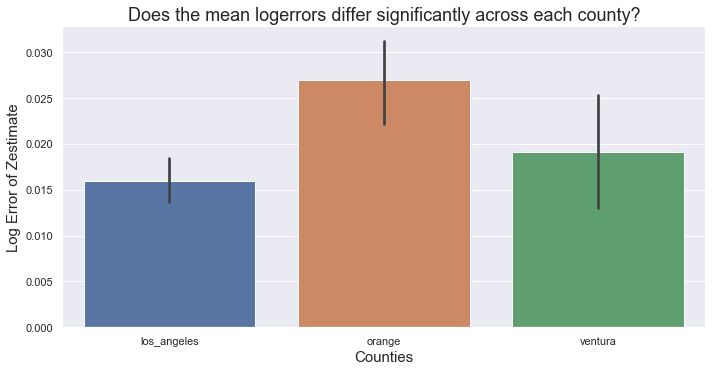

In [9]:
sns.catplot(x="county", y="error", kind="bar", data=train, height=5, aspect=2)
plt.title("Does the mean logerrors differ significantly across each county?", size = 18)
plt.xlabel("Counties", size = 15)
plt.ylabel("Log Error of Zestimate", size = 15)
plt.show()

### Is there a significant difference between the house cost per sqft and logerrors?

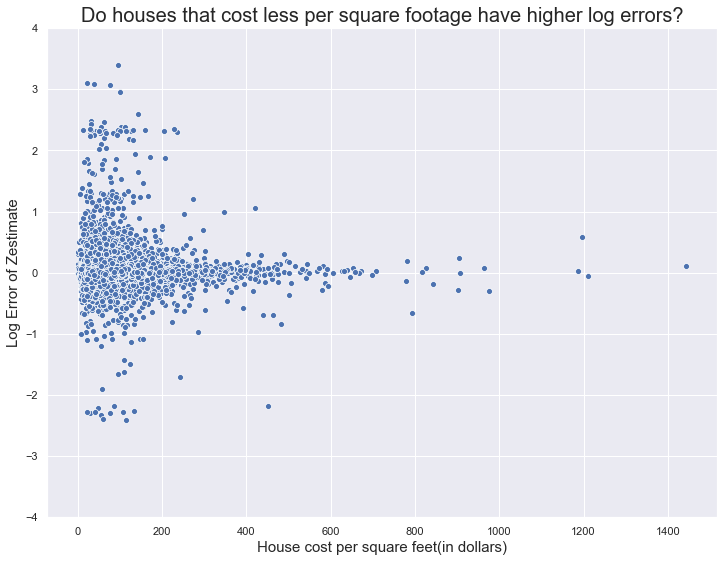

In [10]:
sns.scatterplot(x = 'structure_dollar_per_sqft', y = 'error', data = train)
plt.title("Do houses that cost less per square footage have higher log errors?", size = 20)
plt.xlabel("House cost per square feet(in dollars)", size = 15)
plt.ylabel("Log Error of Zestimate", size = 15)
plt.ylim(-4, 4)
plt.show()

<div class="alert alert-block alert-info"><b>
    Takeaway:</b>
    
- There seems to be a difference between houses that cost less than $200 per sqft but is it significant?
</div>

- $H_0$: Log errors for low cost per sqft houses **are the same** as the log errors for the rest of the houses
- $H_a$: Log errors for low cost per sqft houses **are different** than the log errors for the rest of the houses

In [11]:
low_cost_sqft = train[train.structure_dollar_per_sqft < 200]
t, p = stats.ttest_1samp(low_cost_sqft.error, train.error.mean())
t, p

(0.3241526634826526, 0.7458249674639328)

<div class="alert alert-block alert-info"><b>
    Conclusion:</b>
    
- Although there appears to be a diffence in logerrors, the test shows that it is not a significant one
</div>

### Is there a significant difference in logerrors between bedrooms?

- $H_0$: The mean logerror is the **same** across all bedrooms
- $H_a$: The mean logerror is **not the same** across all bedrooms

In [12]:
one_bed = train[train.bedroomcnt == 1].error
two_bed = train[train.bedroomcnt == 2].error
three_bed = train[train.bedroomcnt == 3].error
four_bed = train[train.bedroomcnt == 5].error
five_bed = train[train.bedroomcnt == 4].error
six_bed = train[train.bedroomcnt == 6].error
seven_bed = train[train.bedroomcnt == 7].error

In [13]:
f, p = f_oneway(one_bed, two_bed, three_bed, four_bed, five_bed, six_bed, seven_bed)

In [14]:
if p < alpha:
    print("We reject the null")
else:
    print("We fail to reject the null")
p

We reject the null


1.2878894227156024e-06

<div class="alert alert-block alert-info"><b>
    Conclusion:</b>
    
- The mean logerror is **not the same** across all bedrooms
</div>

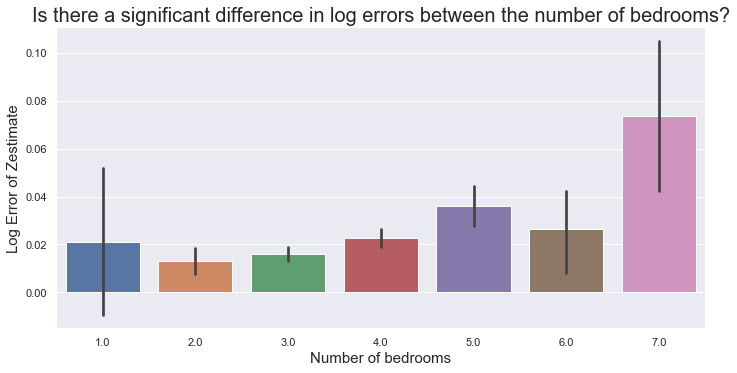

In [15]:
sns.catplot(x="bedroomcnt", y="error", kind="bar", data=train, height=5, aspect=2)
plt.title("Is there a significant difference in log errors between the number of bedrooms?", size = 20)
plt.xlabel("Number of bedrooms", size = 15)
plt.ylabel("Log Error of Zestimate", size = 15)
plt.show()

### Is there a significant difference in logerrors between heating systems?

- $H_0$: The mean logerror is the **same** across all heating systems
- $H_a$: The mean logerror is **not the same** across all heating systems

In [16]:
central_error = train[train.central_heating == 1].error
no_heat_error = train[train.no_heating == 1].error
floor_wall_error = train[train.floor_wall_heating == 1].error

In [17]:
f, p = f_oneway(central_error, no_heat_error, floor_wall_error)

In [18]:
if p < alpha:
    print("We reject the null")
else:
    print("We fail to reject the null")
p

We reject the null


3.0860771893024825e-05

<div class="alert alert-block alert-info"><b>
    Conclusion:</b>
    
- The mean logerror is **not the same** across all heating systems
</div>

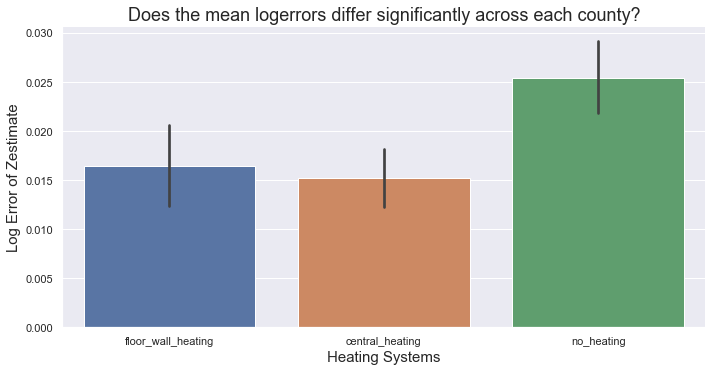

In [19]:
sns.catplot(x="heatingorsystemdesc", y="error", kind="bar", data=train, height=5, aspect=2)
plt.title("Does the mean logerrors differ significantly across each county?", size = 18)
plt.xlabel("Heating Systems", size = 15)
plt.ylabel("Log Error of Zestimate", size = 15)
plt.show()

<div class="alert alert-block alert-info">
</div>

# Clustering

In [20]:
train_scaled, validate_scaled, test_scaled = scaled_zillow_columns()

In [21]:
X_train_scaled = train_scaled.drop(columns=['parcelid', 'transactiondate', 'error'])
y_train_scaled = train_scaled[['error']]
X_validate_scaled = validate_scaled.drop(columns=['parcelid', 'transactiondate', 'error'])
y_validate_scaled = validate_scaled[['error']]
X_test_scaled = test_scaled.drop(columns=['parcelid', 'transactiondate', 'error'])
y_test_scaled = test_scaled[['error']]

In [22]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27955 entries, 32407 to 16021
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   heatingorsystemdesc                  27955 non-null  object 
 1   county                               27955 non-null  object 
 2   los_angeles                          27955 non-null  uint8  
 3   orange                               27955 non-null  uint8  
 4   ventura                              27955 non-null  uint8  
 5   central_heating                      27955 non-null  uint8  
 6   floor_wall_heating                   27955 non-null  uint8  
 7   no_heating                           27955 non-null  uint8  
 8   bedroomcnt_scaled                    27955 non-null  float64
 9   calculatedfinishedsquarefeet_scaled  27955 non-null  float64
 10  fireplacecnt_scaled                  27955 non-null  float64
 11  latitude_scaled         

<div class="alert alert-block alert-info">
    
- We can see what columns we have and start to group them by like columns

- `calculatedfinishedsquarefeet_scaled` and `acres_scaled` are related to the size of the property
    
- `structure_dollar_per_sqft_scaled` and `land_dollar_per_sqft_scaled` are related to the value of the property
    
- `fireplacecnt_scaled`, `poolcnt_scaled`, `central_heating`, `floor_wall_heating` and `no_heating` are all added features for the homes
    
- This seems like a good starting point for clustering
</div>

In [23]:
size_vars = ['calculatedfinishedsquarefeet_scaled', 'acres_scaled']

value_vars = ['structure_dollar_per_sqft_scaled', 'land_dollar_per_sqft_scaled']

feature_vars = ['fireplacecnt_scaled', 'poolcnt_scaled', 'central_heating', 'floor_wall_heating', 'no_heating']

#### Size Cluster

     k         sse
0    2  211.830744
1    3  123.611815
2    4   86.299517
3    5   66.546560
4    6   54.977819
5    7   43.631629
6    8   36.695301
7    9   32.038001
8   10   28.499939
9   11   25.186215
10  12   23.050929
11  13   21.048272
12  14   19.163582
13  15   17.708818
14  16   16.436855
15  17   15.327083
16  18   14.543045
17  19   13.658493


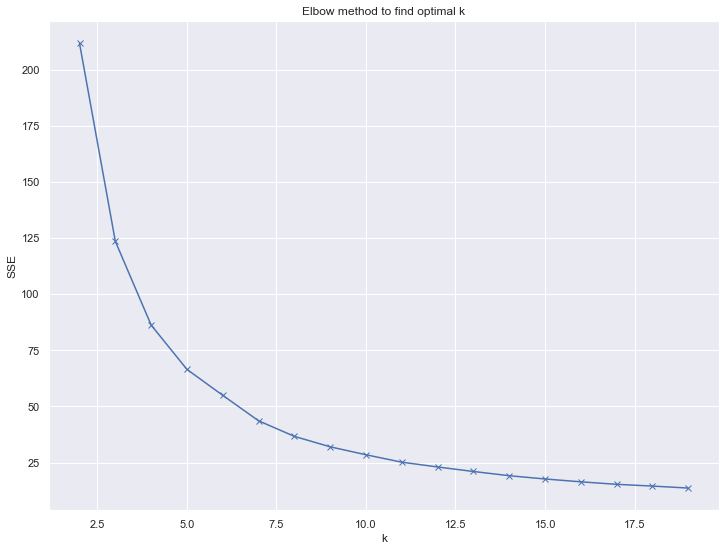

In [24]:
elbow_plot(size_vars, X_train_scaled)

<div class="alert alert-block alert-info"><b>
    Takeaway:</b>
    
- The elbow seems to peak around 5
</div>

In [25]:
train_clusters, kmeans = run_kmeans(5,  cluster_vars = ['calculatedfinishedsquarefeet_scaled', 'acres_scaled'], 
                                    cluster_col_name = 'size_cluster', X_train_scaled = X_train_scaled)

In [26]:
X_train, X_train_scaled = add_to_train(train_clusters, cluster_col_name = 'size_cluster', X_train = X_train, X_train_scaled = X_train_scaled)

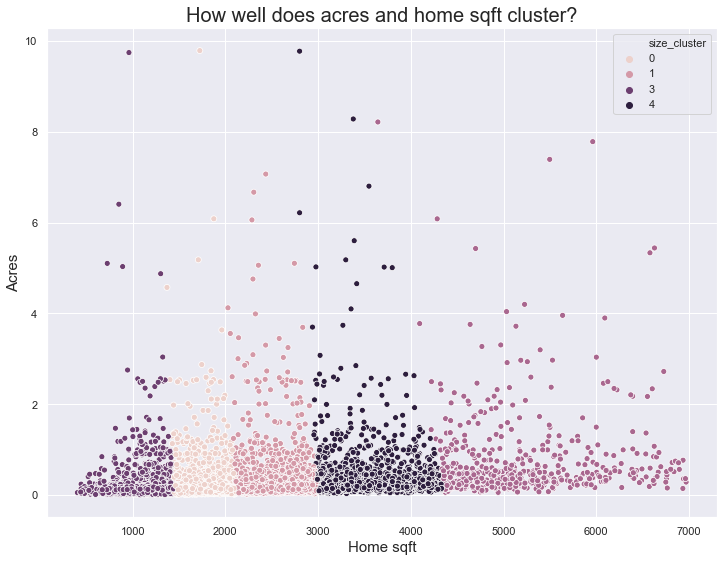

In [27]:
sns.scatterplot(x='calculatedfinishedsquarefeet', y='acres', hue='size_cluster', data=X_train)
plt.title("How well does acres and home sqft cluster?", size = 20)
plt.xlabel("Home sqft", size = 15)
plt.ylabel("Acres", size = 15)
plt.show()

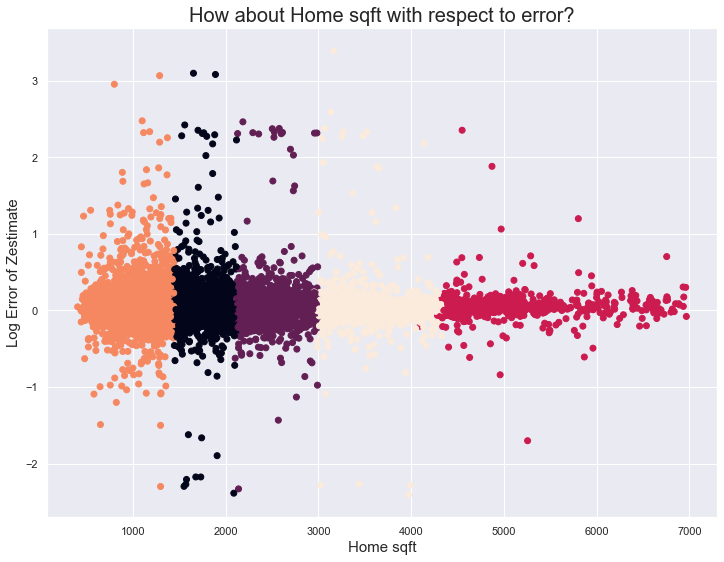

In [28]:
plt.scatter(X_train.calculatedfinishedsquarefeet, y_train.error, c=X_train.size_cluster)
plt.title("How about Home sqft with respect to error?", size = 20)
plt.xlabel("Home sqft", size = 15)
plt.ylabel("Log Error of Zestimate", size = 15)
plt.show()

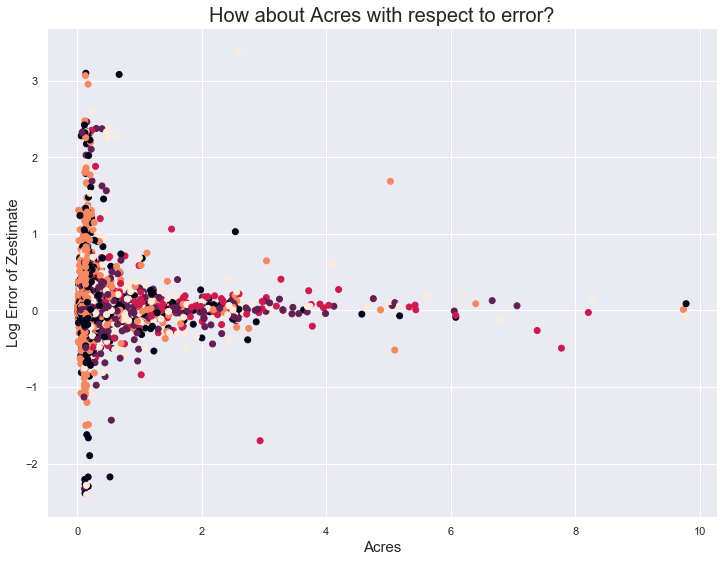

In [29]:
plt.scatter(X_train.acres, y_train.error, c=X_train.size_cluster)
plt.title("How about Acres with respect to error?", size = 20)
plt.xlabel("Acres", size = 15)
plt.ylabel("Log Error of Zestimate", size = 15)
plt.show()

<div class="alert alert-block alert-info"><b>
    Takeaway:</b>
    
- Cluster seem to revolve around home sqft.
- When looking at acres wrt logerrors, a cluster along the loweer bound seems to form. 
- Clusters 0, 1, and 2 may be significant
</div>

In [30]:
train = pd.concat([train, train_clusters], axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27955 entries, 32407 to 16021
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      27955 non-null  int64  
 1   bedroomcnt                    27955 non-null  float64
 2   calculatedfinishedsquarefeet  27955 non-null  float64
 3   fireplacecnt                  27955 non-null  float64
 4   latitude                      27955 non-null  float64
 5   longitude                     27955 non-null  float64
 6   poolcnt                       27955 non-null  float64
 7   regionidcity                  27955 non-null  float64
 8   regionidzip                   27955 non-null  float64
 9   roomcnt                       27955 non-null  float64
 10  transactiondate               27955 non-null  object 
 11  heatingorsystemdesc           27955 non-null  object 
 12  age                           27955 non-null  float64
 1

### Is there a significant difference in logerrors between size clusters?

- $H_0$: The mean logerror is the **same** across all size clusters
- $H_a$: The mean logerror is **not the same** across all size clusters

In [31]:
cluster0 = train[train.size_cluster == 0].error
cluster1 = train[train.size_cluster == 1].error
cluster2 = train[train.size_cluster == 2].error
cluster3 = train[train.size_cluster == 3].error
cluster4 = train[train.size_cluster == 4].error

In [32]:
f, p = f_oneway(cluster0, cluster1, cluster2, cluster3, cluster4)

In [33]:
if p < alpha:
    print("We reject the null")
else:
    print("We fail to reject the null")
p

We reject the null


3.116573999137816e-08

<div class="alert alert-block alert-info"><b>
    Conclusion:</b>
    
- The mean log error is not the same across all size clusters
</div>

In [34]:
train_clusters, kmeans = run_kmeans(5,  cluster_vars = ['calculatedfinishedsquarefeet_scaled', 'acres_scaled'], 
                                    cluster_col_name = 'size_cluster', X_train_scaled = X_validate_scaled)

X_validate_scaled = pd.concat([X_validate_scaled, train_clusters], axis=1)

train_clusters, kmeans = run_kmeans(5,  cluster_vars = ['calculatedfinishedsquarefeet_scaled', 'acres_scaled'], 
                                    cluster_col_name = 'size_cluster', X_train_scaled = X_test_scaled)

X_test_scaled = pd.concat([X_test_scaled, train_clusters], axis=1)

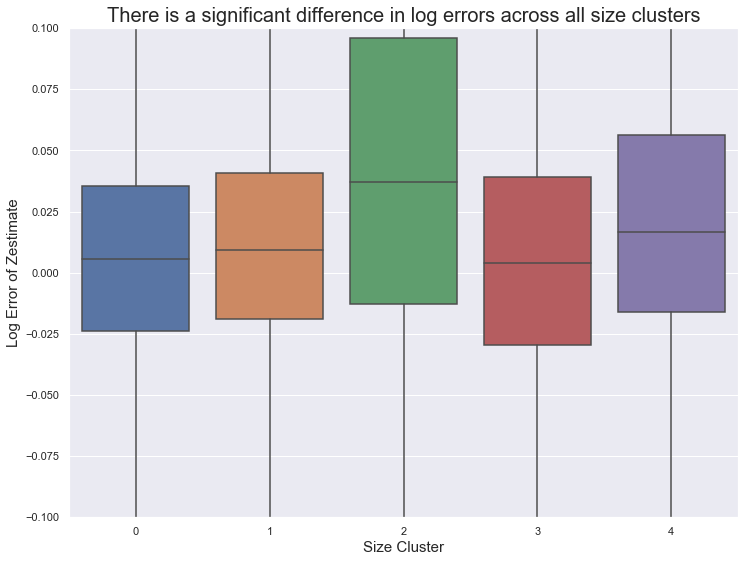

In [35]:
sns.boxplot(X_train.size_cluster, y_train.error)
plt.title("There is a significant difference in log errors across all size clusters", size = 20)
plt.xlabel("Size Cluster", size = 15)
plt.ylabel("Log Error of Zestimate", size = 15)
plt.ylim(-.1,.1)
plt.show()

#### Feature Cluster

     k           sse
0    2  1.299097e+04
1    3  4.636014e+03
2    4  2.421967e+03
3    5  7.180341e+02
4    6  2.597951e+02
5    7  1.169889e+02
6    8  5.324775e+01
7    9  2.909416e+01
8   10  8.320931e+00
9   11  4.059404e+00
10  12  9.193064e-01
11  13  4.271189e-01
12  14  1.772727e-01
13  15  7.983749e-23
14  16  3.961248e-23
15  17  3.961248e-23
16  18  3.961248e-23
17  19  3.961248e-23


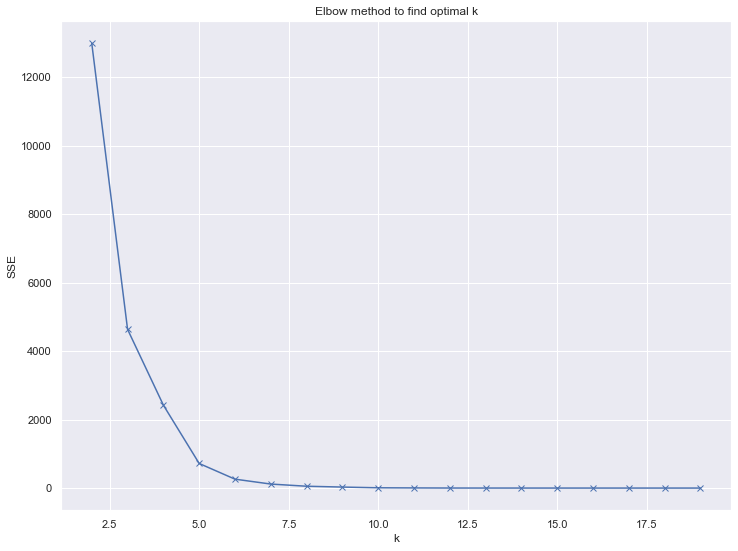

In [36]:
elbow_plot(feature_vars, X_train_scaled)

<div class="alert alert-block alert-info"><b>
    Takeaway:</b>
    
- The elbow seems to peak around 5
</div>

In [37]:
train_clusters, kmeans = run_kmeans(5,  cluster_vars = ['fireplacecnt_scaled', 'poolcnt_scaled', 'central_heating', 'floor_wall_heating', 'no_heating'], 
                                    cluster_col_name = 'feature_cluster', X_train_scaled = X_train_scaled)

In [38]:
X_train, X_train_scaled = add_to_train(train_clusters, cluster_col_name = 'feature_cluster', X_train = X_train, X_train_scaled = X_train_scaled)

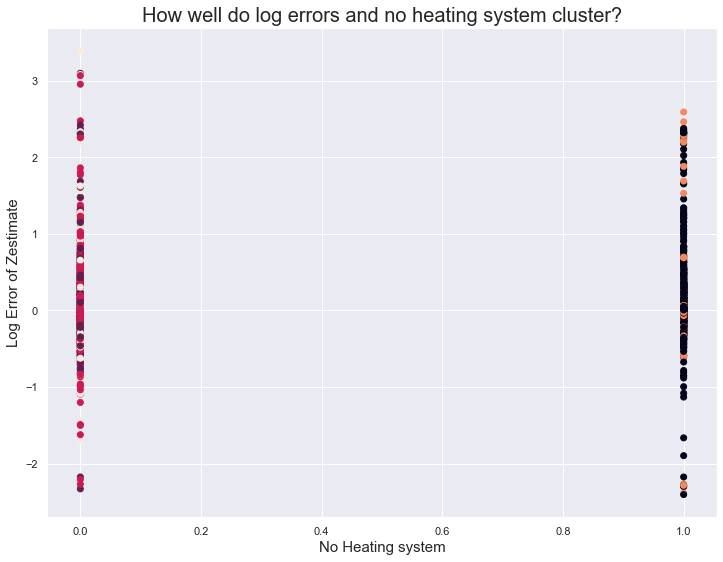

In [39]:
plt.scatter(train.no_heating, y_train.error, c=X_train.feature_cluster)
plt.title("How well do log errors and no heating system cluster?", size = 20)
plt.xlabel("No Heating system", size = 15)
plt.ylabel("Log Error of Zestimate", size = 15)
plt.show()

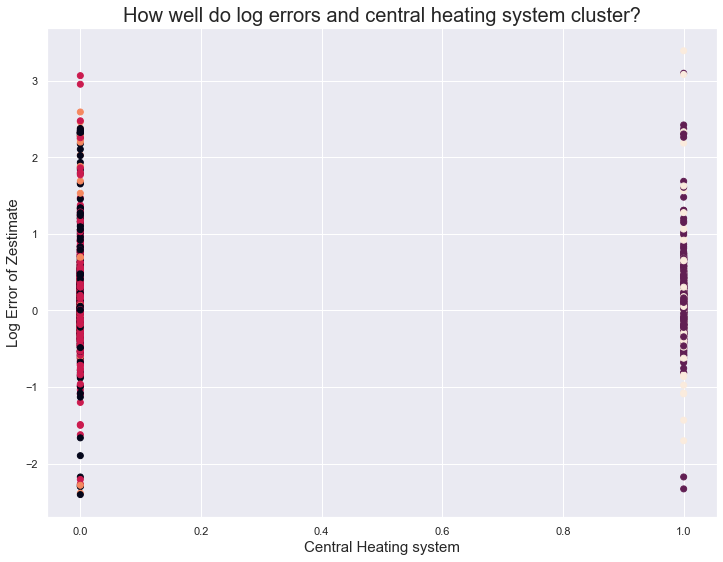

In [40]:
plt.scatter(X_train.central_heating, y_train.error, c=X_train.feature_cluster)
plt.title("How well do log errors and central heating system cluster?", size = 20)
plt.xlabel("Central Heating system", size = 15)
plt.ylabel("Log Error of Zestimate", size = 15)
plt.show()

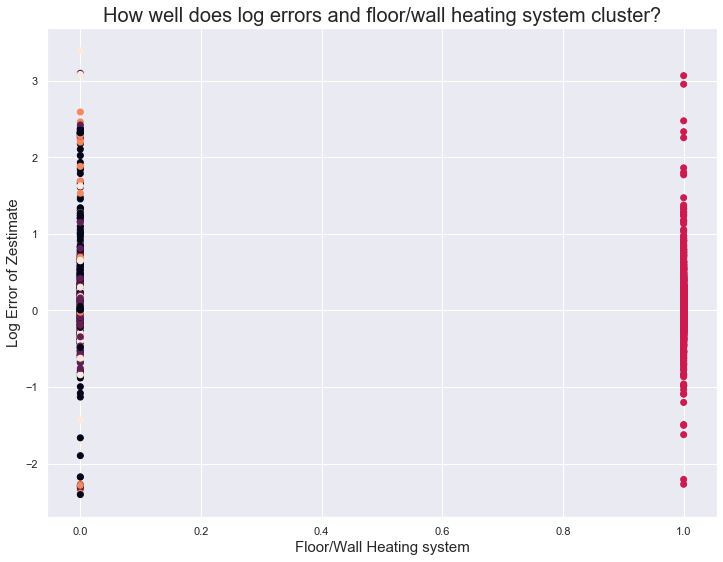

In [41]:
plt.scatter(X_train.floor_wall_heating, y_train.error, c=X_train.feature_cluster)
plt.title("How well does log errors and floor/wall heating system cluster?", size = 20)
plt.xlabel("Floor/Wall Heating system", size = 15)
plt.ylabel("Log Error of Zestimate", size = 15)
plt.show()

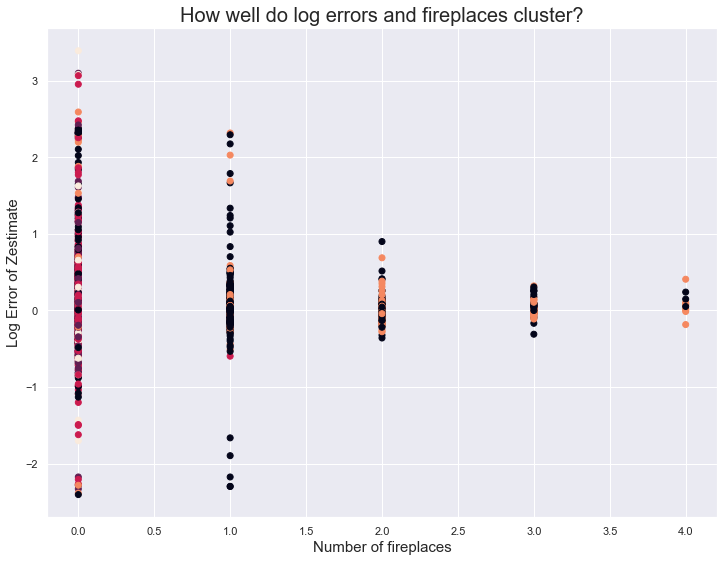

In [42]:
plt.scatter(X_train.fireplacecnt, y_train.error, c=X_train.feature_cluster)
plt.title("How well do log errors and fireplaces cluster?", size = 20)
plt.xlabel("Number of fireplaces", size = 15)
plt.ylabel("Log Error of Zestimate", size = 15)
plt.show()

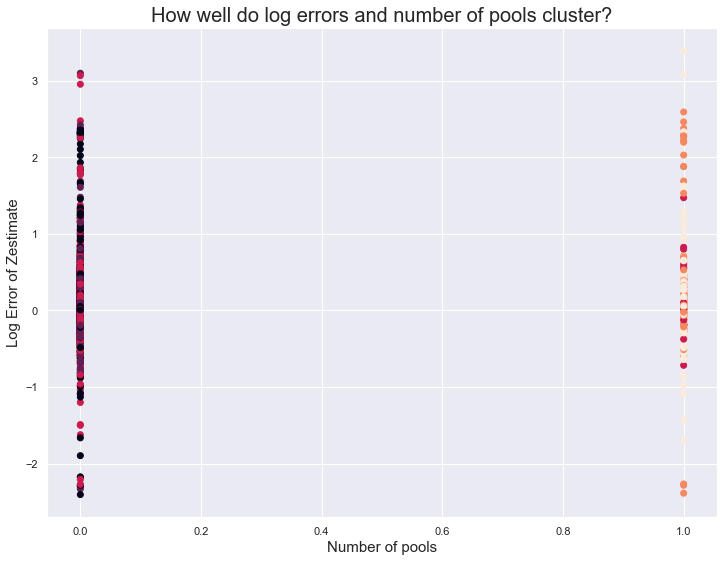

In [43]:
plt.scatter(X_train.poolcnt, y_train.error, c=X_train.feature_cluster)
plt.title("How well do log errors and number of pools cluster?", size = 20)
plt.xlabel("Number of pools", size = 15)
plt.ylabel("Log Error of Zestimate", size = 15)
plt.show()

<div class="alert alert-block alert-info"><b>
    Takeaway:</b>
    
- Clusters seems scattered everywhere but some have more disperity than others

- Let's run a test to see if they are significantly different
</div>

In [44]:
train = pd.concat([train, train_clusters], axis=1)

### Is there a significant difference in logerrors between feature clusters?

- $H_0$: The mean logerror is the **same** across all feature clusters
- $H_a$: The mean logerror is **not the same** across all feature clusters

In [45]:
cluster0 = train[train.feature_cluster == 0].error
cluster1 = train[train.feature_cluster == 1].error
cluster2 = train[train.feature_cluster == 2].error
cluster3 = train[train.feature_cluster == 3].error
cluster4 = train[train.feature_cluster == 4].error

In [46]:
f, p = f_oneway(cluster0, cluster1, cluster2, cluster3, cluster4)

In [47]:
if p < alpha:
    print("We reject the null")
else:
    print("We fail to reject the null")
p

We reject the null


1.3487856595802312e-05

<div class="alert alert-block alert-info"><b>
    Conclusion:</b>
    
- The mean logerror is not the same across all feature clusters
</div>

In [48]:
train_clusters, kmeans = run_kmeans(5,  cluster_vars = ['fireplacecnt_scaled', 'poolcnt_scaled', 'central_heating', 'floor_wall_heating', 'no_heating'], 
                                    cluster_col_name = 'feature_cluster', X_train_scaled = X_validate_scaled)

X_validate_scaled = pd.concat([X_validate_scaled, train_clusters], axis=1)


train_clusters, kmeans = run_kmeans(5,  cluster_vars = ['fireplacecnt_scaled', 'poolcnt_scaled', 'central_heating', 'floor_wall_heating', 'no_heating'], 
                                    cluster_col_name = 'feature_cluster', X_train_scaled = X_test_scaled)

X_test_scaled = pd.concat([X_test_scaled, train_clusters], axis=1)

(-0.5, 0.5)

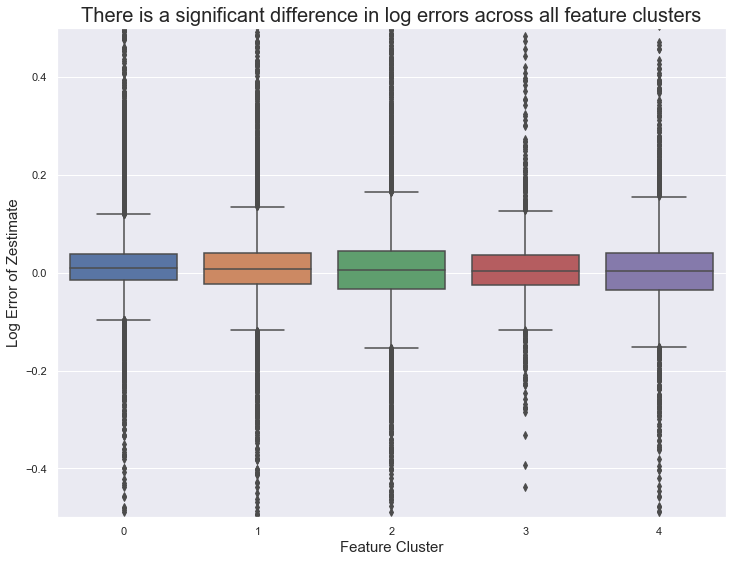

In [49]:
sns.boxplot(X_train.feature_cluster, y_train.error)
plt.title("There is a significant difference in log errors across all feature clusters", size = 20)
plt.xlabel("Feature Cluster", size = 15)
plt.ylabel("Log Error of Zestimate", size = 15)
plt.ylim(-.5,.5)

#### Value Cluster

     k        sse
0    2  57.371925
1    3  42.543350
2    4  34.610725
3    5  27.198953
4    6  22.422738
5    7  19.449347
6    8  16.718406
7    9  14.925144
8   10  13.387054
9   11  12.110369
10  12  11.113269
11  13  10.274531
12  14   9.479210
13  15   8.758422
14  16   8.170375
15  17   7.583675
16  18   7.191445
17  19   6.812366


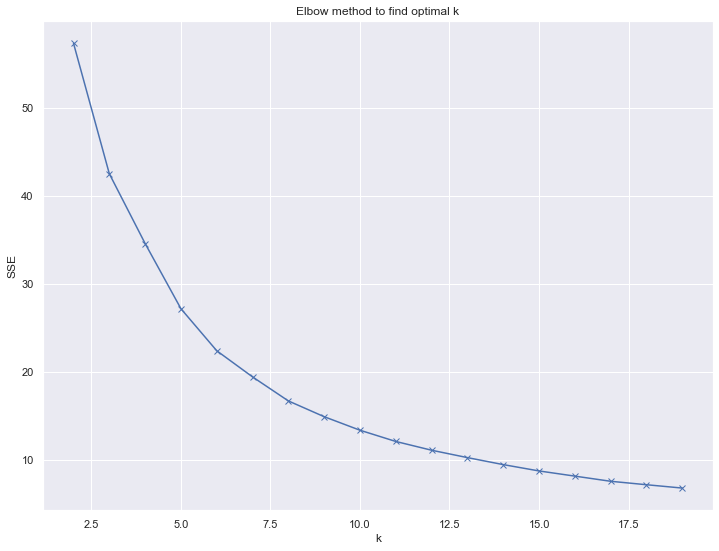

In [50]:
elbow_plot(value_vars, X_train_scaled)

<div class="alert alert-block alert-info"><b>
    Takeaway:</b>
    
- The elbow seems to peak at 6
</div>

In [51]:
train_clusters, kmeans = run_kmeans(6,  cluster_vars = ['structure_dollar_per_sqft_scaled', 'land_dollar_per_sqft_scaled'], 
                                    cluster_col_name = 'value_cluster', X_train_scaled = X_train_scaled)

In [52]:
X_train, X_train_scaled = add_to_train(train_clusters, cluster_col_name = 'value_cluster', X_train = X_train, X_train_scaled = X_train_scaled)

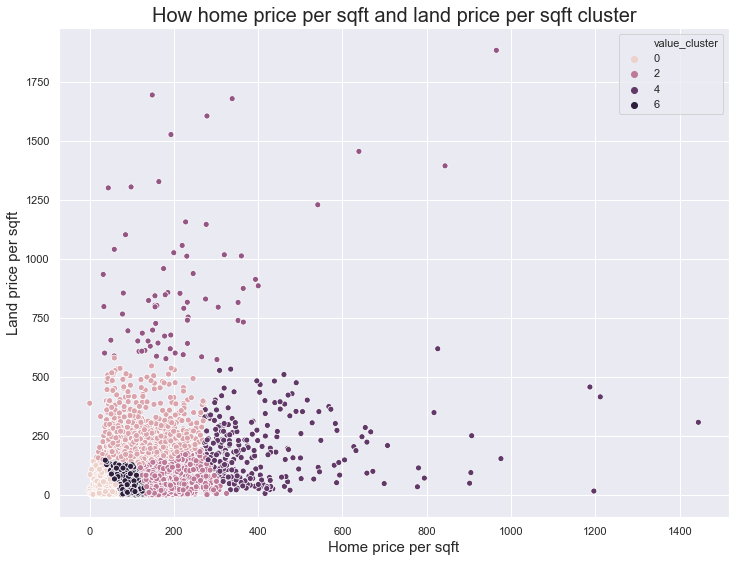

In [53]:
sns.scatterplot(x='structure_dollar_per_sqft', y='land_dollar_per_sqft', hue='value_cluster', data=X_train)
plt.title("How home price per sqft and land price per sqft cluster", size = 20)
plt.xlabel("Home price per sqft", size = 15)
plt.ylabel("Land price per sqft", size = 15)
plt.show()

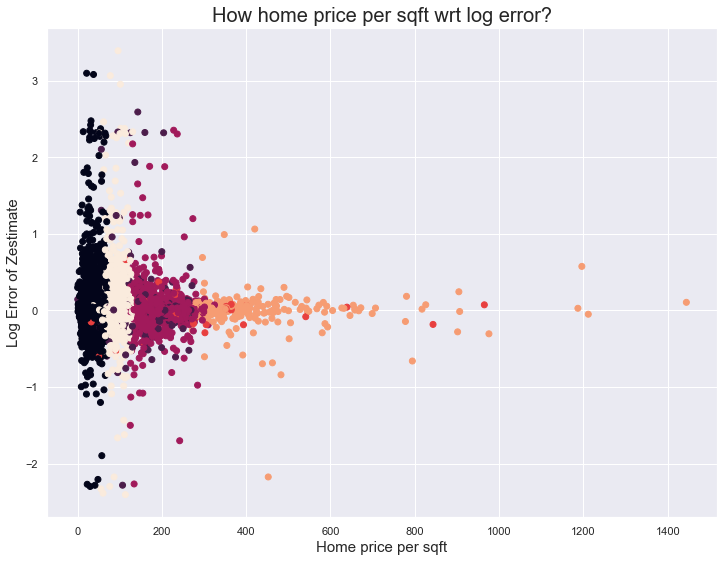

In [54]:
plt.scatter(train.structure_dollar_per_sqft, train.error, c=X_train.value_cluster)
plt.title("How home price per sqft wrt log error?", size = 20)
plt.xlabel("Home price per sqft", size = 15)
plt.ylabel("Log Error of Zestimate", size = 15)
plt.show()

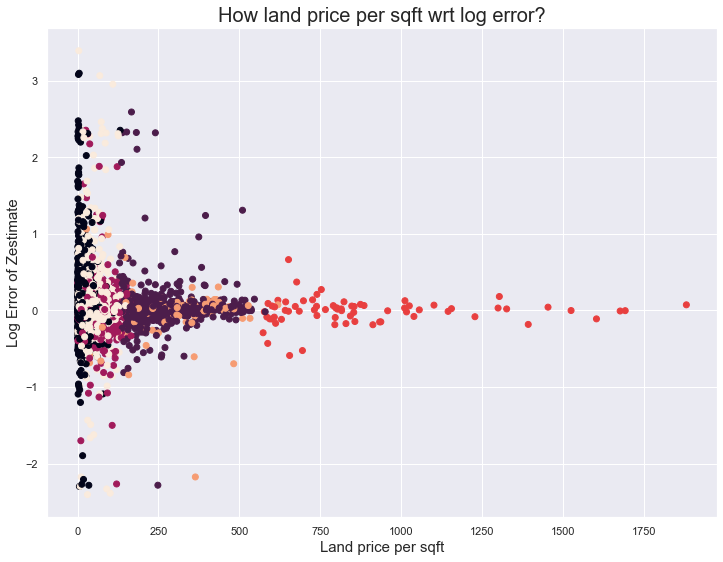

In [55]:
plt.scatter(X_train.land_dollar_per_sqft, y_train.error, c=X_train.value_cluster)
plt.title("How land price per sqft wrt log error?", size = 20)
plt.xlabel("Land price per sqft", size = 15)
plt.ylabel("Log Error of Zestimate", size = 15)
plt.show()

<div class="alert alert-block alert-info"><b>
    Takeaway:</b>
    
- Cluster 0 and 1 seem to have the greatest errors
    
- Cluster 5 is fairly accurate on log errors
</div>

In [56]:
train = pd.concat([train, train_clusters], axis=1)

### Is there a significant difference in logerrors between value clusters?

- $H_0$: The mean logerror is the **same** across all value clusters
- $H_a$: The mean logerror is **not the same** across all value clusters

In [57]:
cluster0 = train[train.value_cluster == 0].error
cluster1 = train[train.value_cluster == 1].error
cluster2 = train[train.value_cluster == 2].error
cluster3 = train[train.value_cluster == 3].error
cluster4 = train[train.value_cluster == 4].error
cluster5 = train[train.value_cluster == 5].error

In [58]:
f, p = f_oneway(cluster0, cluster1, cluster2, cluster3, cluster4)

In [59]:
if p < alpha:
    print("We reject the null")
else:
    print("We fail to reject the null")
p

We reject the null


4.615914248209213e-07

<div class="alert alert-block alert-info"><b>
    Conclusion:</b>
    
- The mean logerror is not the same across all value clusters
</div>

In [60]:
train_clusters, kmeans = run_kmeans(6,  cluster_vars = ['structure_dollar_per_sqft_scaled', 'land_dollar_per_sqft_scaled'], 
                                    cluster_col_name = 'value_cluster', X_train_scaled = X_validate_scaled)
X_validate_scaled = pd.concat([X_validate_scaled, train_clusters], axis=1)

train_clusters, kmeans = run_kmeans(6,  cluster_vars = ['structure_dollar_per_sqft_scaled', 'land_dollar_per_sqft_scaled'], 
                                    cluster_col_name = 'value_cluster', X_train_scaled = X_test_scaled)
X_test_scaled = pd.concat([X_test_scaled, train_clusters], axis=1)

(-0.5, 0.5)

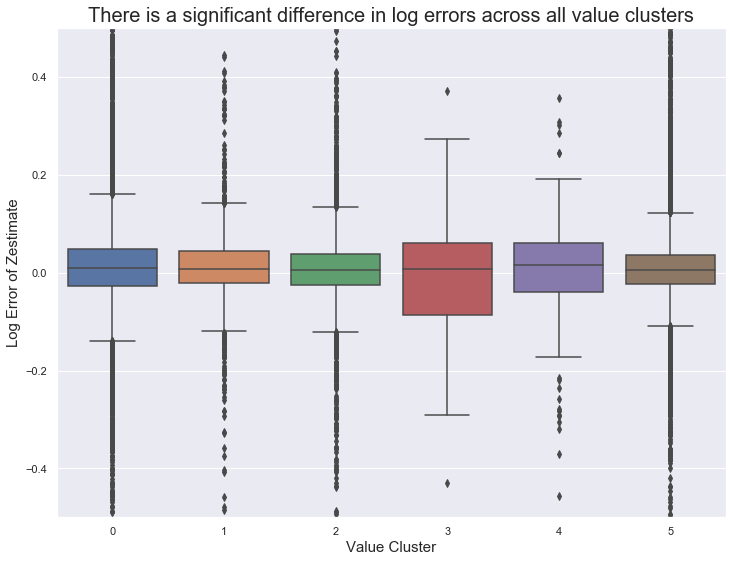

In [61]:
sns.boxplot(X_train.value_cluster, y_train.error)
plt.title("There is a significant difference in log errors across all value clusters", size = 20)
plt.xlabel("Value Cluster", size = 15)
plt.ylabel("Log Error of Zestimate", size = 15)
plt.ylim(-.5,.5)

- Creating dummy variables for modeling

In [62]:
dummy_df = pd.get_dummies(X_train_scaled,
                           columns=['size_cluster','feature_cluster', 'value_cluster'], 
                           drop_first=True)

X_train_scaled = dummy_df.drop(columns=['heatingorsystemdesc', 'county'])

dummy_df = pd.get_dummies(X_validate_scaled,
                           columns=['size_cluster','feature_cluster', 'value_cluster'], 
                           drop_first=True)

X_validate_scaled = dummy_df.drop(columns=['heatingorsystemdesc', 'county'])

dummy_df = pd.get_dummies(X_test_scaled,
                           columns=['size_cluster','feature_cluster', 'value_cluster'], 
                           drop_first=True)

X_test_scaled = dummy_df.drop(columns=['heatingorsystemdesc', 'county'])

# Modeling

#### Ranking our Features

In [68]:
lm = LinearRegression()
rfe_ = RFE(lm, 1)
rfe_.fit(X_train_scaled, y_train)
ranks = rfe_.ranking_
names = X_train_scaled.columns.tolist()
pd.DataFrame({'features': names, 'rank': ranks}).sort_values('rank')

,features,rank
5,no_heating,1
25,feature_cluster_1,2
26,feature_cluster_2,3
28,feature_cluster_4,4
4,floor_wall_heating,5
3,central_heating,6
2,ventura,7
1,orange,8
0,los_angeles,9
18,structure_dollar_per_sqft_scaled,10


#### Setting a Baseline

In [70]:
lm = LinearRegression()
lm.fit(X_train_scaled, y_train.error)
y_hat = lm.predict(X_train_scaled)

baseline_rmse = round(mean_squared_error(y_train.error, y_hat)**(1/2), 7)
baseline_rmse

0.1710961

## Model 1 (No Cluster)
- We will choose the top "5" features
- Heating system, county, home price per sqft, acres, and tax rate

In [71]:
X_train_no_cluster = X_train_scaled[['no_heating','floor_wall_heating', 'central_heating', 'ventura', 'orange', 'los_angeles', 'structure_dollar_per_sqft_scaled', 'acres_scaled', 'taxrate_scaled']]
y_train = train_scaled[['error']]
X_validate_no_cluster = X_validate_scaled[['no_heating','floor_wall_heating', 'central_heating', 'ventura', 'orange', 'los_angeles', 'structure_dollar_per_sqft_scaled', 'acres_scaled', 'taxrate_scaled']]
y_validate = validate_scaled[['error']]
X_test_no_cluster = X_test_scaled[['no_heating','floor_wall_heating', 'central_heating', 'ventura', 'orange', 'los_angeles', 'structure_dollar_per_sqft_scaled', 'acres_scaled', 'taxrate_scaled']]
y_test = test_scaled[['error']]

In [72]:
lm_rmse = round(linearReg_train(X_train_no_cluster, y_train),7)

lm_rmse

0.1714865

In [73]:
lars_rmse = round(lassoLars_train(X_train_no_cluster, y_train),7)

lars_rmse

0.1717059

In [74]:
lm_squared_rmse = round(poly_linearReg_train(X_train_no_cluster, y_train, 2),7)

lm_squared_rmse

0.1712604

# Model 2 (Mix)
- We will use some of the top feature clusters along with county, home price per sqft, acres, and taxrate

In [75]:
X_train_mix_cluster = X_train_scaled[['feature_cluster_1','feature_cluster_2', 'feature_cluster_4', 'ventura', 'orange', 'los_angeles', 'structure_dollar_per_sqft_scaled', 'acres_scaled', 'taxrate_scaled']]
y_train = train_scaled[['error']]
X_validate_mix_cluster = X_validate_scaled[['feature_cluster_1','feature_cluster_2', 'feature_cluster_4', 'ventura', 'orange', 'los_angeles', 'structure_dollar_per_sqft_scaled', 'acres_scaled', 'taxrate_scaled']]
y_validate = validate_scaled[['error']]
X_test_mix_cluster = X_test_scaled[['feature_cluster_1','feature_cluster_2', 'feature_cluster_4', 'ventura', 'orange', 'los_angeles', 'structure_dollar_per_sqft_scaled', 'acres_scaled', 'taxrate_scaled']]
y_test = test_scaled[['error']]

In [76]:
lm_rmse2 = round(linearReg_train(X_train_mix_cluster, y_train),7)

lm_rmse2

0.1714782

In [77]:
lars_rmse2 = round(lassoLars_train(X_train_mix_cluster, y_train),7)

lars_rmse2

0.1717059

In [78]:
lm_squared_rmse2 = round(poly_linearReg_train(X_train_mix_cluster, y_train, 2),7)

lm_squared_rmse2

0.171229

In [79]:
print("Baseline, Mean: ", baseline_rmse)
print("Linear Regression Model 1: ", lm_rmse)
print("Linear Regression Model 2: ", lm_rmse2)
print("LassoLars Model 1: ", lars_rmse)
print("LassoLars Model 2: ", lars_rmse2)
print("Polynomial Squared Model 1: ", lm_squared_rmse)
print("Polynomial Squared Model 2: ", lm_squared_rmse2)

Baseline, Mean:  0.1710961
Linear Regression Model 1:  0.1714865
Linear Regression Model 2:  0.1714782
LassoLars Model 1:  0.1717059
LassoLars Model 2:  0.1717059
Polynomial Squared Model 1:  0.1712604
Polynomial Squared Model 2:  0.171229


# Validate Model 1

In [80]:
lm_rmse_val = round(linearReg_validate(X_train_no_cluster, y_train, X_validate_no_cluster, y_validate),7)

lm_rmse_val

0.1769554

In [81]:
lars_rmse_val = round(lassoLars_validate(X_train_no_cluster, y_train, X_validate_no_cluster, y_validate),7)

lars_rmse_val

0.1771172

In [82]:
lm_squared_rmse_val = round(poly_linearReg_validate(X_train_no_cluster, y_train, X_validate_no_cluster, y_validate, 2),7)

lm_squared_rmse_val

0.1770168

# Validate Model 2

In [83]:
lm_rmse_val2 = round(linearReg_validate(X_train_mix_cluster, y_train, X_validate_mix_cluster, y_validate),7)

lm_rmse_val

0.1769554

In [84]:
lars_rmse_val2 = round(lassoLars_validate(X_train_mix_cluster, y_train, X_validate_mix_cluster, y_validate),7)

lars_rmse_val

0.1771172

In [85]:
lm_squared_rmse_val2 = round(poly_linearReg_validate(X_train_mix_cluster, y_train, X_validate_mix_cluster, y_validate, 2),7)

lm_squared_rmse_val2

11820383026.117908

In [86]:
print("       Models       |      Train      |      Validate")
print("Baseline, Mean: ", baseline_rmse)
print("Linear Regression Model 1: ", lm_rmse, lm_rmse_val)
print("Linear Regression Model 2: ", lm_rmse2, lm_rmse_val2)
print("LassoLars Model 1: ", lars_rmse, lars_rmse_val)
print("LassoLars Model 2: ", lars_rmse2, lars_rmse_val2)
print("Polynomial Squared Model 1: ", lm_squared_rmse, lm_squared_rmse_val)
print("Polynomial Squared Model 2: ", lm_squared_rmse2, lm_squared_rmse_val2)

       Models       |      Train      |      Validate
Baseline, Mean:  0.1710961
Linear Regression Model 1:  0.1714865 0.1769554
Linear Regression Model 2:  0.1714782 0.1772265
LassoLars Model 1:  0.1717059 0.1771172
LassoLars Model 2:  0.1717059 0.1771172
Polynomial Squared Model 1:  0.1712604 0.1770168
Polynomial Squared Model 2:  0.171229 11820383026.117908


<div class="alert alert-block alert-info"><b>
    Conclusion:</b>
    
- The model that performed the best overall is the Polynomial Squared Model 1
- Polynomial Squared Model 2 definitely overfit the first model
- LassoLars performed the same, with and without the clusters
- We will move onto test
</div>

# Test

In [87]:
lm_squared_rmse_val = round(poly_linearReg_validate(X_train_no_cluster, y_train, X_test_no_cluster, y_test, 2),7)

lm_squared_rmse_val

0.1725849

# Conclusion

<div class="alert alert-block alert-info">

- Many of the original data was scraped due to a high number of null values. 
    
- There was a high correlation between `structure_dollar_per_sqft`, `calculatedfinishedsquarefeet` and `bedroomcnt` to the log error. 
    
- The Polynomial Squared Model 1 perfomed the best but was 1.47% worse than the baseline
</div>

# Next Steps
If alloted more time

<div class="alert alert-block alert-info">
    
- We can further explore the original data to see if we can save any data.
    
- We could try different combinations of clustering 

- We could further analyze the outliers and possibly remove some more so we can increase performance on our model.
    
- We can see if there is a relationship between what time of the year a transaction happened and the logerror
  
- We could further divide up the dataframes and build models by county
</div>